# Analisis de la barra

In [14]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Longitud de la barra

r50= 1.11649
r90= 15.2737
log(M+/Msol)= 9.85056852856
A2max= 0.158823996206 rmax= 0.436109900475
lbar= 0.503602942142


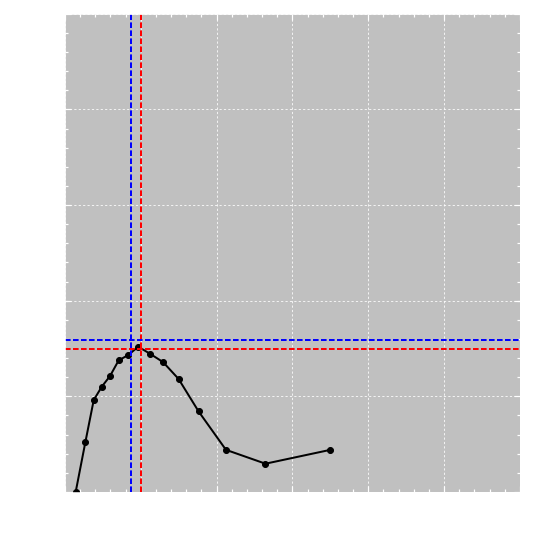

In [12]:
import h5py
import rotation as rot
import time_conversion as tiempo
import barstrength as strng
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

aa = np.loadtxt('/home/ornela/python/ornella/redshift_outputs.txt')
aexp = aa[:,2]

snapshot=range(290, 289,-1)
for isnap in snapshot:
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    #print isnap
    cm   = snap['subhalo_000/Center'].value
    r200 = snap['subhalo_000/R200'].value
    #aexp = snap['subhalo_000/Time'].value

    pstr = snap['subhalo_000/Str/Coordinates'].value
    #IDs = snap['subhalo_000/Str/Ids'].value
    masa_str = snap['subhalo_000/Str/Masses'].value
    vel  = snap['subhalo_000/Str/Velocities'].value
    
    z = a0/aexp[isnap] - 1.
    Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    t = tiempo.conv(z, h, omega_lambda, omega_matter)

    #---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    r = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

    #----------------------masas----------------------------
    masa_str = masa_str/h

    r200 = r200*aexp[isnap]/h
    rgal=0.15*r200

    limit = np.where(r<rgal)
    r_sort = np.sort(r[limit])
    r_indice = np.argsort(r[limit])

    Mc_str = cumsum((masa_str[limit])[r_indice])
    M_gal = Mc_str[-1]

    #------------------ calculamos M90------------------------------------------
    razon = Mc_str/M_gal
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa]
    r50 = r_sort[cincuenta]
    M90 = Mc_str[noventa]
    
    print 'r50=', r50[-1]
    print 'r90=', r90[-1]
    print r'log(M+/Msol)=', log10(M_gal*1e10)

    veloc,=np.where(r<r50[-1])

    #----------componentes de la velocidad del centro de masa------------
    vxcm = sum(masa_str[veloc]*v_x[veloc])/sum(masa_str[veloc])
    vycm = sum(masa_str[veloc]*v_y[veloc])/sum(masa_str[veloc])
    vzcm = sum(masa_str[veloc]*v_z[veloc])/sum(masa_str[veloc])

    #----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm
    
    dd = range(496,300,-1)
    dd.remove(428)
    if isnap in dd:
        raux = 2*r50[-1]
        #print 'primero', isnap
    elif (isnap == 428) or ((isnap < 301) & (isnap > 283)):
        #print 'segundo', isnap
        raux = r50[-1]
    elif (isnap > 271) & (isnap < 284):
        raux = 0.75
        #print 'tercero', isnap
    elif isnap < 272:
        raux = 0.5
        #print 'cuarto', isnap
    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(masa_str,xstr,ystr,zstr,vx,vy,vz,raux)
    
    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
    corte1,=np.where(r<rgal)
    
#     if isnap in range(256,272):
#         corte2 = np.where(r<0.75)
#     else:
#         corte2 = np.where(r<raux)

    corte2, = np.where(r<raux)
    corte3, = np.where(r<2*r50[-1])
    
    A2, phi, rbin = strng.a2(masa_str[corte3], xn[corte3], yn[corte3], 15)
    
    A2max, rmax, phi = strng.a2max(masa_str[corte2], xn[corte2], yn[corte2], 15)
    
    print 'A2max=', A2max, 'rmax=', rmax
    
    mask, =np.where((rbin >= rmax))
    point = A2[mask]
    rr = rbin[mask]
    
    hbar = 0.15
    resta = point - hbar

    for kk,_ in enumerate(point):
        if resta[kk] < 0:
            break
            
    pend = (point[kk] - point[kk-1])/(rr[kk]-rr[kk-1])
    y0 = (point[kk-1]*rr[kk]-point[kk]*rr[kk-1])/(rr[kk]-rr[kk-1])
    
    lbar = (hbar - y0)/pend
    
    print 'lbar=', lbar
    
    fig = plt.figure(2,figsize=(8,8))
    fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
    ax=fig.add_subplot(111)
    ax.plot(rbin,A2,'ko-', lw=2, color = 'k')
    ax.set_ylim(0,0.5)
    ax.set_xlim(0,3)
    #ax.set_title('subhalo_0'+ str('%s'%vector[i]), fontsize=24)
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.minorticks_on()
    ax.tick_params( labelsize=22, colors='w')
    ax.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on',colors='w')
    ax.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on',colors='w')  
    ax.set_facecolor('silver')
    ax.grid(color='w',linestyle=':',which='major')
    #ax.grid(color='lightgray',linestyle=':',which='minor')
    ax.set_xlabel(r'$tiempo$ $[Gyr]$', fontsize=26, color='w')
    ax.set_ylabel(r'$A_{2}^{max}$',fontsize=26, color='w')
    ax.axvline(x=lbar, color='r', lw=2, ls='--')
    ax.axhline(y=hbar, color='r', lw=2, ls='--')
    ax.axvline(x=rmax, color='b', lw=2, ls='--')
    ax.axhline(y=A2max, color='b', lw=2, ls='--')
#     plt.text(x = 2, y = 0.43, 
#              s =r'$R_{max}=$' +str('%.3f'%rmax)+', $A_{2}^{max}=$' + str('%.3f'%A2max),
#              fontsize = 20, va= 'center', ha= 'left', color = 'k')
#     plt.annotate('$l_{bar} =$'+ '%.2f'%lbar, xy=(lbar,0), xytext=(0, +80), textcoords='offset points', 
#                          fontsize=22,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.1),ha="center")
    
    plt.show()

In [4]:
x = np.array([1,2,3,4,5,6])
for k,_ in enumerate(x):
    print k

0
1
2
3
4
5


## Contracción Masa de materia oscura

In [14]:
import h5py
import rotation as rot
import time_conversion as tiempo
import barstrength as strng

#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

aa = np.loadtxt('/home/ornela/python/ornella/redshift_outputs.txt')
aexp = aa[:,2]

snapshot=range(496,0,-1) #SNAPSHOTS

for isnap in snapshot:
    
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    
    cm   = snap['subhalo_000/Center'].value
    r200 = snap['subhalo_000/R200'].value
    pdrk = snap['subhalo_000/Drk/Coordinates'].value
    mdrk = snap['subhalo_000/Drk/Masses'].value
    
    z = a0/aexp[isnap] - 1.
    Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    time = tiempo.conv(z, h, omega_lambda, omega_matter)

#paso las coordenadas respecto al centro de la galaxia
    xdrk = (pdrk[:,0]-cm[0])*aexp[isnap]/h
    ydrk = (pdrk[:,1]-cm[1])*aexp[isnap]/h
    zdrk = (pdrk[:,2]-cm[2])*aexp[isnap]/h
    r = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

#------------------------------------------------
    mdrk = mdrk/h #masa a unidades físicas

    r200 = r200*aexp[isnap]/h #radio virial a unidades fisicas

    limit1 = np.where(r < 0.5)
    r_ind1 = np.argsort(r[limit1])
    
    limit2 = np.where(r < 1.0)
    r_ind2 = np.argsort(r[limit2])
    
    limit3 = np.where(r < 1.5)
    r_ind3 = np.argsort(r[limit3])

    Mc_05 = cumsum(mdrk[limit1][r_ind1])
    Mdrk_05 = Mc_05[-1]
    
    Mc_10 = cumsum(mdrk[limit2][r_ind2])
    Mdrk_10 = Mc_10[-1]
    
    Mc_15 = cumsum(mdrk[limit3][r_ind3])
    Mdrk_15 = Mc_15[-1]
    
#Guargamos los parámetros en distintos archivos
#----------------------------------------------------------------------------------
    archivo1 =  open('/home/ornela/python/barras/Mdrk_time.dat','a')
    archivo1.write(str('%03d'%isnap) +'\t'+
            str('%12.6f'% time) +'\t'+
            str('%12.6f'% np.log10(Mdrk_05*1e10)) +'\t'+
            str('%12.6f'% np.log10(Mdrk_10*1e10)) +'\t'+
            str('%12.6f'% np.log10(Mdrk_15*1e10)) +'\n')
    archivo1.close()
#------------------------------------------------------------------------------------

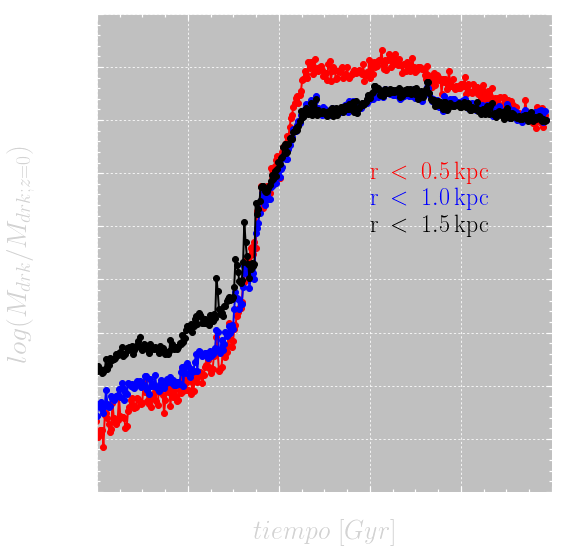

In [29]:
from __future__ import unicode_literals
from scipy import interpolate

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True


cm = np.loadtxt('/home/ornela/python/barras/Mdrk_time.dat')

time    = cm[:,1]
Mdrk_05 = cm[:,2]
Mdrk_10 = cm[:,3]
Mdrk_15 = cm[:,4]

fig = plt.figure(1,figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax=fig.add_subplot(111)
ax.plot(time,Mdrk_05-Mdrk_05[0],'ro-', lw=2)
ax.plot(time,Mdrk_10-Mdrk_10[0],'bo-', lw=2)
ax.plot(time,Mdrk_15-Mdrk_15[0],'ko-', lw=2)
ax.set_ylim(-0.35,0.1)
ax.set_xlim(4,14)
ax.spines['bottom'].set_color('w')
ax.spines['top'].set_color('w')
ax.spines['left'].set_color('w')
ax.spines['right'].set_color('w')
ax.minorticks_on()
ax.tick_params( labelsize=22, colors='lightgray')
ax.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on',colors='w')
ax.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on',colors='w')  
ax.set_facecolor('silver')
ax.grid(color='w',linestyle=':',which='major')
#ax.grid(color='lightgray',linestyle=':',which='minor')
ax.set_xlabel(r'$tiempo$ $[Gyr]$', fontsize=26, color='lightgray')
ax.set_ylabel(r'$log(M_{drk}/M_{drk;z=0})$',fontsize=28, color='lightgray')
plt.text(x = 10, y = -0.05, s =r'$\mathrm{r\:<\:0.5\:kpc}$',
         fontsize = 24, va= 'center', ha= 'left', color = 'r')
plt.text(x = 10, y = -0.075, s =r'$\mathrm{r\:<\:1.0\:kpc}$',
         fontsize = 24, va= 'center', ha= 'left', color = 'b')
plt.text(x = 10, y = -0.1, s =r'$\mathrm{r\:<\:1.5\:kpc}$',
         fontsize = 24, va= 'center', ha= 'left', color = 'k')

plt.show()

## Radio de corotación en funcion del tiempo

In [16]:
import h5py
import rotation as rot
import time_conversion as tiempo
from scipy import interpolate
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

aa   = np.loadtxt('/home/ornela/python/ornella/redshift_outputs.txt')
aexp = aa[:,2]

cm0   = np.loadtxt('/home/ornela/python/barras/derivada_phi_time.dat')
dphi = cm0[:,1]
dphi = dphi/360.

cm1   = np.loadtxt('/home/ornela/python/barras/omegabar_time2.dat')
ombar = cm1[:,2]
ombar = ombar/(2.*pi)


snapshot=range(496,250,-1) #SNAPSHOTS
i = 0
for isnap in snapshot:
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    
    cm   = snap['subhalo_000/Center'].value
    r200 = snap['subhalo_000/R200'].value
    
    pstr = snap['subhalo_000/Str/Coordinates'].value
    mstr = snap['subhalo_000/Str/Masses'].value
#     vel  = snap['subhalo_000/Str/Velocities'].value

    pgas = snap['subhalo_000/Gas/Coordinates'].value
    mgas = snap['subhalo_000/Gas/Masses'].value

    pdrk = snap['subhalo_000/Drk/Coordinates'].value
    mdrk = snap['subhalo_000/Drk/Masses'].value
        
    z    = a0/aexp[isnap] - 1.
    Ht   = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    time = tiempo.conv(z, h, omega_lambda, omega_matter)
        
#paso las coordenadas respecto al centro de la galaxia
    xstr = (pstr[:,0]-cm[0]) * aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1]) * aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2]) * aexp[isnap]/h
    rstr = np.sqrt(xstr**2 + ystr**2 + zstr**2)
        
    xgas = (pgas[:,0]-cm[0]) * aexp[isnap]/h
    ygas = (pgas[:,1]-cm[1]) * aexp[isnap]/h
    zgas = (pgas[:,2]-cm[2])* aexp[isnap]/h
    rgas = np.sqrt(xgas**2 + ygas**2 + zgas**2)
        
    xdrk = (pdrk[:,0]-cm[0]) * aexp[isnap]/h
    ydrk = (pdrk[:,1]-cm[1]) * aexp[isnap]/h
    zdrk = (pdrk[:,2]-cm[2]) * aexp[isnap]/h
    rdrk = np.sqrt(xdrk**2 + ydrk**2 + zdrk**2)
     
# #paso las velocidades a unidades físicas
#     v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
#     v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
#     v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.
    
#masas a unidades físicas
    mstr = mstr/h
    mgas = mgas/h
    mdrk = mdrk/h

    r200 = r200*aexp[isnap]/h #radio virial a unidades fisicas

    rgal = 0.15*r200 #defino el radio de la galaxia

    limit = np.where(rstr < rgal)      #hago un límite de los r dentro de rgal
    r_sort = np.sort(rstr[limit])      #acomodo los r de menor a mayor
    r_indice = np.argsort(rstr[limit]) #saco los argumentos de r acomodados de menor a mayor

    Mc_str = cumsum(mstr[limit][r_indice]) #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1] #masa total de la galaxia

    #Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa

#-----------------------------------------------------------------------

#Cálculo de la velocidad circular
    
    rtot = concatenate([rstr,rgas,rdrk])
    mtot = concatenate([mstr, mgas, mdrk])

    limit_tot   = np.where(rtot < r200)
    rtot_sort   = np.sort(rtot[limit_tot])
    rtot_indice = np.argsort(rtot[limit_tot])

    Mc_tot = cumsum(mtot[limit_tot][rtot_indice])
        
    Vtot = np.sqrt((G*Mc_tot*1e10)/rtot_sort)
    
#     Vvir = Vtot[-1]
    omega = Vtot/(rtot_sort*2.*pi)
    
#--------------------------------------------------------------
#Interpolamos para calcular el radio de corotación
    
#     for kk,_ in enumerate(rtot_sort):
#         if omega[kk] < dphi[i]:
#             break
            
#     pend = (omega[kk] - omega[kk-1]) / (rtot_sort[kk] - rtot_sort[kk-1])
#     y0 = (omega[kk-1]*rtot_sort[kk] - omega[kk]*rtot_sort[kk-1]) / (rtot_sort[kk] - rtot_sort[kk-1])
    
#     r_corot0 = (dphi[i]- y0)/ pend #calculado para la derivada del phi
#_____________________________________________________________________

    for kk,_ in enumerate(rtot_sort):
        if omega[kk] < ombar[i]:
            break
            
    pend = (omega[kk] - omega[kk-1]) / (rtot_sort[kk] - rtot_sort[kk-1])
    y0 = (omega[kk-1]*rtot_sort[kk] - omega[kk]*rtot_sort[kk-1]) / (rtot_sort[kk] - rtot_sort[kk-1])
    
    r_corot1 = (ombar[i]- y0)/ pend #calculado con el elipsoide

#     print rtot_sort
#     print 'vel_phi=', dphi[i]
#     print 'vel_elip=', ombar[i]
    
#     print 'r_corot0 =', r_corot0, '#calculado con phi'
#     print 'r_corot1 =', r_corot1, '#calculado con la veloc del elipsoide'

#Guargamos los parámetros en distintos archivos
#-------------------------------------------------------------------------------------
#     archivo1 =  open('/home/ornela/python/barras/rcorot_phi_time.dat','a')
#     archivo1.write(str('%03d'% isnap) +'\t'+
#                str('%12.6f'% time) +'\t'+
#                str('%12.6f'% r_corot0) +'\n')
#     archivo1.close()
    
    archivo2 =  open('/home/ornela/python/barras/rcorot_elip_time2.dat','a')
    archivo2.write(str('%03d'% isnap) +'\t'+
               str('%12.6f'% time) +'\t'+
               str('%12.6f'% r_corot1) +'\n')
    archivo2.close()
#--------------------------------------------------------------------------------------
    i += 1   

#test
#--------------------------------------------------------------------------------------
#     fig = plt.figure(1,figsize=(8,8))
#     fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)    
#     ax1=fig.add_subplot(111)
#     ax1.plot(rtot_sort,omega,'ko-', lw=2)
#     ax1.set_ylim(0,20)
#     ax1.set_xlim(-1,10)
#     ax1.spines['bottom'].set_color('w')
#     ax1.spines['top'].set_color('w')
#     ax1.spines['left'].set_color('w')
#     ax1.spines['right'].set_color('w')
#     ax1.minorticks_on()
#     ax1.tick_params( labelsize=22, colors='lightgray')
#     ax1.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on',colors='w')
#     ax1.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on',colors='w')  
#     ax1.set_facecolor('silver')
#     ax1.grid(color='w',linestyle=':',which='major')
#     #ax1.grid(color='lightgray',linestyle=':',which='minor')
#     ax1.set_xlabel(r'$tiempo$ $[Gyr]$', fontsize=26, color='lightgray')
#     ax1.set_ylabel(r'$R_{corot}$',fontsize=26, color='lightgray')
#     ax1.axvline(x=r_corot0, color='r', lw=2, ls='--')
#     ax1.axhline(y=dphi[i], color='r', lw=2, ls='--')
#     ax1.axvline(x=r_corot1, color='b', lw=2, ls='--')
#     ax1.axhline(y=ombar[i], color='b', lw=2, ls='--')



/home/ornela/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:114: RuntimeWarning: divide by zero encountered in divide


## Rcorot y Lbar en funcion del tiempo

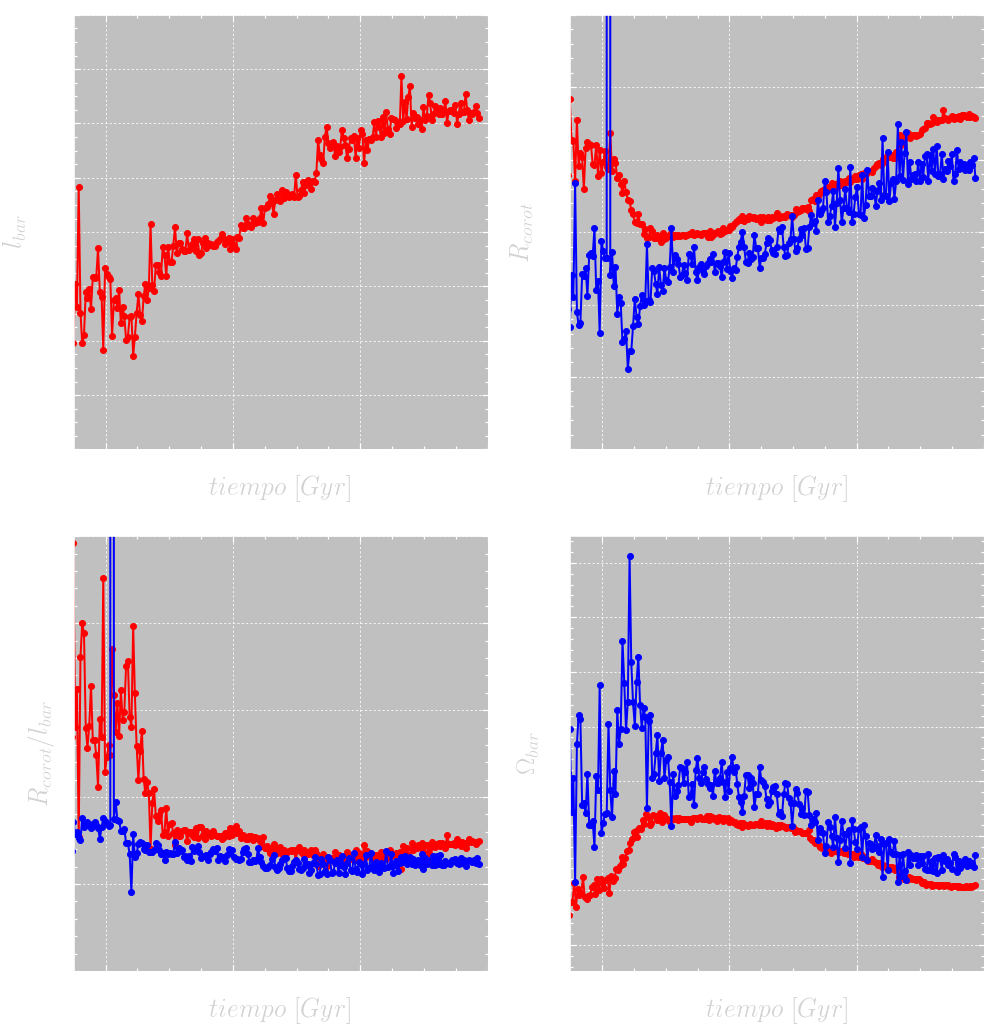

In [15]:
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True


cm0      = np.loadtxt('/home/ornela/python/barras/rcorot_phi_time.dat')
time0    = cm0[:,1]
rcor_phi = cm0[:,2]

cm1       = np.loadtxt('/home/ornela/python/barras/rcorot_elip_time2.dat')
time1     = cm1[:,1]
rcor_elip = cm1[:,2]

cm2   = np.loadtxt('/home/ornela/python/barras/lbar_time2.dat')
time2 = cm2[:,1]
lbar  = cm2[:,2]

cm3   = np.loadtxt('/home/ornela/python/barras/derivada_phi_time.dat')
time3 = cm3[:,0]
dphi  = cm3[:,1]
dphi  = dphi/360.

cm4   = np.loadtxt('/home/ornela/python/barras/omegabar_time2.dat')
time4 = cm4[:,1]
ombar = cm4[:,2]
ombar = ombar/(2.*pi)


fig = plt.figure(1,figsize=(16,16))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax0=fig.add_subplot(221)
ax0.plot(time2,lbar,'ro-', lw=2)
ax0.set_ylim(0.,2)
ax0.set_xlim(7.5,14)
ax0.spines['bottom'].set_color('w')
ax0.spines['top'].set_color('w')
ax0.spines['left'].set_color('w')
ax0.spines['right'].set_color('w')
ax0.minorticks_on()
ax0.tick_params( labelsize=22, colors='lightgray')
ax0.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on',colors='w')
ax0.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on',colors='w')  
ax0.set_facecolor('silver')
ax0.grid(color='w',linestyle=':',which='major')
#ax0.grid(color='lightgray',linestyle=':',which='minor')
ax0.set_xlabel(r'$tiempo$ $[Gyr]$', fontsize=26, color='lightgray')
ax0.set_ylabel(r'$l_{bar}$',fontsize=26, color='lightgray')


ax1=fig.add_subplot(222)
ax1.plot(time0,rcor_phi,'ro-', lw=2)
ax1.plot(time1,rcor_elip,'bo-', lw=2)
ax1.set_ylim(0,3)
ax1.set_xlim(7.5,14)
ax1.spines['bottom'].set_color('w')
ax1.spines['top'].set_color('w')
ax1.spines['left'].set_color('w')
ax1.spines['right'].set_color('w')
ax1.minorticks_on()
ax1.tick_params( labelsize=22, colors='lightgray')
ax1.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on',colors='w')
ax1.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on',colors='w')  
ax1.set_facecolor('silver')
ax1.grid(color='w',linestyle=':',which='major')
#ax1.grid(color='lightgray',linestyle=':',which='minor')
ax1.set_xlabel(r'$tiempo$ $[Gyr]$', fontsize=26, color='lightgray')
ax1.set_ylabel(r'$R_{corot}$',fontsize=26, color='lightgray')

ax2=fig.add_subplot(223)
ax2.plot(time0,rcor_phi/lbar[:len(rcor_phi)],'ro-', lw=2)
ax2.plot(time1,rcor_elip/lbar[:len(rcor_elip)],'bo-', lw=2)
ax2.set_ylim(0,5)
ax2.set_xlim(7.5,14)
ax2.spines['bottom'].set_color('w')
ax2.spines['top'].set_color('w')
ax2.spines['left'].set_color('w')
ax2.spines['right'].set_color('w')
ax2.minorticks_on()
ax2.tick_params( labelsize=22, colors='lightgray')
ax2.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on',colors='w')
ax2.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on',colors='w')  
ax2.set_facecolor('silver')
ax2.grid(color='w',linestyle=':',which='major')
#ax2.grid(color='lightgray',linestyle=':',which='minor')
ax2.set_xlabel(r'$tiempo$ $[Gyr]$', fontsize=26, color='lightgray')
ax2.set_ylabel(r'$R_{corot}/l_{bar}$',fontsize=26, color='lightgray')

ax3=fig.add_subplot(224)
ax3.plot(time3, dphi, 'ro-', lw=2)
ax3.plot(time4, ombar, 'bo-', lw=2)
#ax3.set_ylim(0.96,1.01)
ax3.set_xlim(7.5,14)
ax3.spines['bottom'].set_color('w')
ax3.spines['top'].set_color('w')
ax3.spines['left'].set_color('w')
ax3.spines['right'].set_color('w')
ax3.minorticks_on()
ax3.tick_params( labelsize=22, colors='lightgray')
ax3.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on',colors='w')
ax3.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on',colors='w')  
ax3.set_facecolor('silver')
ax3.grid(color='w',linestyle=':',which='major')
#ax3.grid(color='lightgray',linestyle=':',which='minor')
ax3.set_xlabel(r'$tiempo$ $[Gyr]$', fontsize=26, color='lightgray')
ax3.set_ylabel(r'$\Omega_{bar}$',fontsize=26, color='lightgray')



plt.show()

In [97]:
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import sphviewer as sph
import numpy as np
import time_conversion as tiempo
from scipy import interpolate

h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

aa = np.loadtxt('/home/ornela/python/ornella/redshift_outputs.txt')
aexp = aa[:,2]

cm=np.loadtxt('/home/ornela/python/barra/momento_ang_fin.dat')
omega_bar =cm[:,2]
omega_bar = omega_bar/(2*pi)


snapshot=range(496,250,-1)
ii = 0
for isnap in snapshot:
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    print isnap
    fo =open('/home/ornela/python/barra/rcorot_lbar_vs_time2.dat','a')
    
    cm   = snap['subhalo_000/Center'].value
    r200 = snap['subhalo_000/R200'].value
    #aexp = snap['subhalo_0'+ str('%s' %vector[i])+ '/Time'].value

    pstr = snap['subhalo_000/Str/Coordinates'].value
    masa_str = snap['subhalo_000/Str/Masses'].value
    vel  = snap['subhalo_000/Str/Velocities'].value

    pgas = snap['subhalo_000/Gas/Coordinates'].value
    masa_gas = snap['subhalo_000/Gas/Masses'].value

    pdrk = snap['subhalo_000/Drk/Coordinates'].value
    masa_drk = snap['subhalo_000/Drk/Masses'].value
        
    z = a0/aexp[isnap] - 1.
    Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    t = tiempo.conv(z, h, omega_lambda, omega_matter)
        
#---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    r = np.sqrt(xstr**2+ystr**2+zstr**2)
        
    xgas = (pgas[:,0]-cm[0])*aexp[isnap]/h
    ygas = (pgas[:,1]-cm[1])*aexp[isnap]/h
    zgas = (pgas[:,2]-cm[2])*aexp[isnap]/h
    rgas = np.sqrt(xgas**2+ygas**2+zgas**2)
        
    xdrk = (pdrk[:,0]-cm[0])*aexp[isnap]/h
    ydrk = (pdrk[:,1]-cm[1])*aexp[isnap]/h
    zdrk = (pdrk[:,2]-cm[2])*aexp[isnap]/h
    rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)
         
    v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.
#----------------------masas----------------------------
    masa_str = masa_str/h
    masa_gas = masa_gas/h
    masa_drk = masa_drk/h

    r200 = r200*aexp[isnap]/h

    #print 'r200 =', r200
    rgal=0.15*r200

    limit = np.where(r<rgal)
    r_sort = np.sort(r[limit])
    r_indice = np.argsort(r[limit])

    Mgal_str = cumsum((masa_str[limit])[r_indice])

    #------------------ calculamos r90, r50------------------------------------------
    M_gal = Mgal_str[-1]

    razon = Mgal_str/M_gal
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa]
    r50 = r_sort[cincuenta]
#---------CALCULAMOS EL Lbar-------------------------------------------  

    veloc,=np.where(r<r50[-1])
    #----------componentes de la velocidad del centro de masa------------
    vxcm = sum(masa_str[veloc]*v_x[veloc])/sum(masa_str[veloc])
    vycm = sum(masa_str[veloc]*v_y[veloc])/sum(masa_str[veloc])
    vzcm = sum(masa_str[veloc]*v_z[veloc])/sum(masa_str[veloc])

    #----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm
    
    dd = range(496,300,-1)
    dd.remove(428)
    if isnap in dd:
        raux = 2*r50[-1]
        #print 'primero', isnap
    elif (isnap == 428) or ((isnap < 301) & (isnap > 283)):
        #print 'segundo', isnap
        raux = r50[-1]
    elif (isnap > 271) & (isnap < 284):
        raux = 0.75
        #print 'tercero', isnap
    elif isnap < 272:
        raux = 0.5
        #print 'cuarto', isnap
    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(masa_str,xstr,ystr,zstr,vx,vy,vz,raux)
    
    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
    corte1,=np.where(r<rgal)
    
    if isnap in range(256,272):
        corte2 = np.where(r<0.75)
    else:
        corte2 = np.where(r<raux)
    
    A2, phi, rbin = strng.a2(masa_str[corte1], xn[corte1], yn[corte1], 20)
    
    A2max, rmax, phi = strng.a2max(masa_str[corte2], xn[corte2], yn[corte2], 20)
    
    mask, =np.where((rbin > rmax))
    point = A2[mask]
    rr = rbin[mask]
    hbar = 0.15
    for kk in range(0,len(point)):
        resta = point[kk]-hbar
        if resta < 0:
            break
    pend = (point[kk] - point[kk-1])/(rr[kk]-rr[kk-1])
    y0 = (point[kk-1]*rr[kk]-point[kk]*rr[kk-1])/(rr[kk]-rr[kk-1])
    lbar = (hbar - y0)/pend
    
    #print 'lbar', lbar
    
#-------------------- PARA EL RADIO DE COROTACION-----------
    rtot= concatenate([r,rgas,rdrk])
    mtot= concatenate([masa_str, masa_gas, masa_drk])

    limit_tot = np.where(rtot<r200)
    rtot_sort = np.sort(rtot[limit_tot])
    rtot_indice = np.argsort(rtot[limit_tot])

    Mc_tot = cumsum((mtot[limit_tot])[rtot_indice])

    Vtot = np.sqrt((G*Mc_tot*1e10)/rtot_sort) #VELOCIDAD CIRCULAR TOTAL
    Vvir = Vtot[-1]
    omega = Vtot/(rtot_sort*2*pi)

    interpolacion = interpolate.interp1d(omega, rtot_sort)
    r_corot = interpolacion(omega_bar[ii])
#     print r_corot
#     print omega_bar[ii]

    fo.write(str('%s'%isnap)+'\t'+
            str('%12.6f'%t)+'\t'+
            str('%12.6f'%lbar)+'\t'+
            str('%12.6f'%r_corot)+'\t'+
            str('%12.6f'%omega_bar[ii])+'\n')
    fo.close()
    
    ii+=1

496
495
494
493
492
491
490
489
488
487
486
485
484
483
482
481
480
479
478
477
476
475
474
473
472
471
470
469
468
467
466
465
464
463
462
461
460
459
458
457
456


/home/ornela/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:166: RuntimeWarning: divide by zero encountered in divide


455
454
453
452
451
450
449
448
447
446
445
444
443
442
441
440
439
438
437
436
435
434
433
432
431
430
429
428
427
426
425
424
423
422
421
420
419
418
417
416
415
414
413
412
411
410
409
408
407
406
405
404
403
402
401
400
399
398
397
396
395
394
393
392
391
390
389
388
387
386
385
384
383
382
381
380
379
378
377
376
375
374
373
372
371
370
369
368
367
366
365
364
363
362
361
360
359
358
357
356
355
354
353
352
351
350
349
348
347
346
345
344
343
342
341
340
339
338
337
336
335
334
333
332
331
330
329
328
327
326
325
324
323
322
321
320
319
318
317
316
315
314
313
312
311
310
309
308
307
306
305
304
303
302
301
300
299
298
297
296
295
294
293
292
291
290
289
288
287
286
285
284
283
282
281
280
279
278
277
276
275
274
273
272
271
270
269
268
267
266
265
264
263
262
261
260
259
258
257
256
255
254
253
252
251


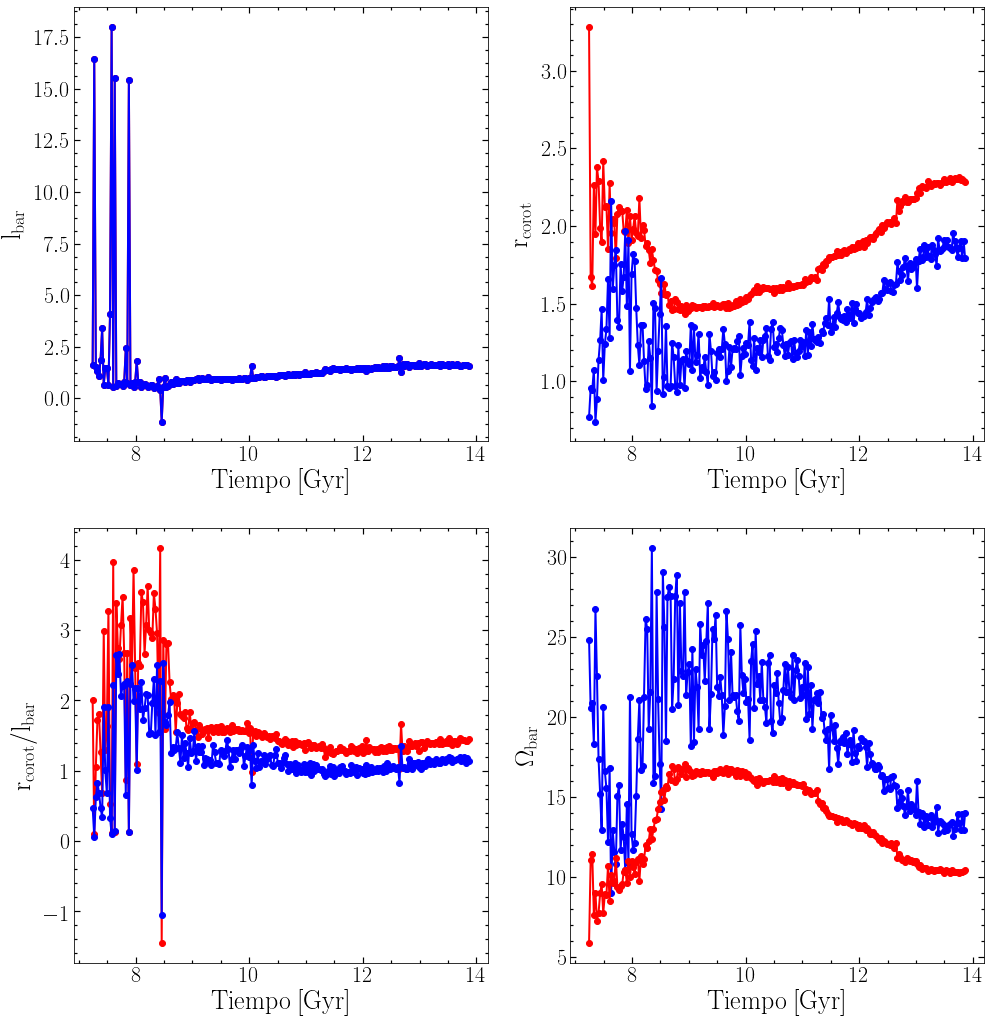

In [102]:
from __future__ import unicode_literals
from scipy import interpolate

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

cm = np.loadtxt('/home/ornela/python/barra/rcorot_lbar_vs_time.dat')

time = cm[:,1]
lbar = cm[:,2]
r_corot = cm[:,3]
Omega_bar = cm[:,4]

cm2 = np.loadtxt('/home/ornela/python/barra/rcorot_lbar_vs_time2.dat')

time2 = cm2[:,1]
lbar2 = cm2[:,2]
r_corot2 = cm2[:,3]
Omega_bar2 = cm2[:,4]

fig = plt.figure(1,figsize=(16,16))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax0=fig.add_subplot(221)
ax0.plot(time,lbar,'ro-', lw=2)
ax0.plot(time2,lbar2,'bo-', lw=2)
#ax0.set_ylim(0.,5)
#ax0.set_xlim(4,14)
ax0.set_xlabel(r'$\mathrm{Tiempo\:[Gyr]}$', fontsize=26)
ax0.set_ylabel(r'$\mathrm{l_{bar}}$', fontsize=26)
ax0.minorticks_on()
ax0.tick_params( labelsize=22)
ax0.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')
ax0.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')

ax1=fig.add_subplot(222)
ax1.plot(time,r_corot,'ro-', lw=2)
ax1.plot(time2,r_corot2,'bo-', lw=2)
#ax1.set_ylim(0.96,1.01)
#ax1.set_xlim(4,14)
ax1.set_xlabel(r'$\mathrm{Tiempo\:[Gyr]}$', fontsize=26)
ax1.set_ylabel(r'$\mathrm{r_{corot}}$', fontsize=26)
ax1.minorticks_on()
ax1.tick_params( labelsize=22)
ax1.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')
ax1.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')

ax2=fig.add_subplot(223)
ax2.plot(time,r_corot/lbar,'ro-', lw=2)
ax2.plot(time2,r_corot2/lbar2,'bo-', lw=2)
#ax2.set_ylim(0.96,1.01)
#ax2.set_xlim(4,14)
ax2.set_xlabel(r'$\mathrm{Tiempo\:[Gyr]}$', fontsize=26)
ax2.set_ylabel(r'$\mathrm{r_{corot}/l_{bar}}$', fontsize=26)
ax2.minorticks_on()
ax2.tick_params( labelsize=22)
ax2.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')
ax2.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')

ax3=fig.add_subplot(224)
ax3.plot(time2,Omega_bar2,'bo-', lw=2)
ax3.plot(time,Omega_bar,'ro-', lw=2)
#ax3.set_ylim(0.96,1.01)
#ax3.set_xlim(4,14)
ax3.set_xlabel(r'$\mathrm{Tiempo\:[Gyr]}$', fontsize=26)
ax3.set_ylabel(r'$\mathrm{\Omega_{bar}}$', fontsize=26)
ax3.minorticks_on()
ax3.tick_params( labelsize=22)
ax3.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')
ax3.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')

In [39]:
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import sphviewer as sph
import numpy as np
import time_conversion as tiempo

h=0.732
a0=1
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
G = 4.299e-6

aa = np.loadtxt('/home/ornela/python/ornella/redshift_outputs.txt')
aexp = aa[:,2]

#fo =open('/home/ornela/python/fdisc.dat','a')

snapshot=range(309,308,-1)
for isnap in snapshot:

    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    pstr = snap['subhalo_000/Str/Coordinates'].value
    cm   = snap['subhalo_000/Center'].value
    vel  = snap['subhalo_000/Str/Velocities'].value
    masa_str = snap['subhalo_000/Str/Masses'].value
    r200 = snap['subhalo_000/R200'].value

    pgas = snap['subhalo_000/Gas/Coordinates'].value
    masa_gas = snap['subhalo_000/Gas/Masses'].value

    pdrk = snap['subhalo_000/Drk/Coordinates'].value
    masa_drk = snap['subhalo_000/Drk/Masses'].value
        
#-------------paso las coordenadas respecto al centro de la galaxia------------------
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    r = np.sqrt(xstr**2+ystr**2+zstr**2)

    xgas = (pgas[:,0]-cm[0])*aexp[isnap]/h
    ygas = (pgas[:,1]-cm[1])*aexp[isnap]/h
    zgas = (pgas[:,2]-cm[2])*aexp[isnap]/h
    rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

    xdrk = (pdrk[:,0]-cm[0])*aexp[isnap]/h
    ydrk = (pdrk[:,1]-cm[1])*aexp[isnap]/h
    zdrk = (pdrk[:,2]-cm[2])*aexp[isnap]/h
    rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

#---------------masas------------------------------------
    masa_str = masa_str/h
    masa_gas = masa_gas/h
    masa_drk = masa_drk/h

    r200 = r200*aexp[isnap]/h
    rgal=0.15*r200

    limit = np.where(r<rgal)
    r_sort = np.sort(r[limit])
    r_indice = np.argsort(r[limit])

    Mc_str = cumsum((masa_str[limit])[r_indice])

#----------------------calculamos r50---------------------------    
    M_gal = Mc_str[-1]

    razon = Mgal_str/M_gal
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa]
    r50 = r_sort[cincuenta]

#----------calculamos la masa total----------------------
    rtot= concatenate([r,rgas,rdrk])
    mtot= concatenate([masa_str, masa_gas, masa_drk])

    limit_tot = np.where(rtot<r200)
    rtot_sort = np.sort(rtot[limit_tot])
    rtot_indice = np.argsort(rtot[limit_tot])

    Mc_tot = cumsum((mtot[limit_tot])[rtot_indice])
    M_total = Mc_tot*1e10

#-------------calculamos la velocidad maxima a r50 y Vstr---------------------
    V50 = np.sqrt((G*M_total[cincuenta])/rtot_sort[cincuenta])
    V_50 = V50[-1]
    Vdisc = np.sqrt((G*Mc_str[-1]*1e10)/r50[-1])
    
    Vtot = np.sqrt((G*Mc_tot*1e10)/rtot_sort)
    Vmax = max(Vtot)
#------------calculamos el parametro de inestabilidad del disco----------------
    fdisc = V_50/Vdisc
    
    print 'f_disc=', fdisc
    
    fdec = V_50/Vmax
    
    print 'f_dec=', fdec

#     fo.write(str('%.6f'% t) +'\t'+
#              str('%12.6f'% epsilon) +'\n')
#     fo.close()
        
        

f_disc= 0.890701305895
f_dec= 0.981484


In [11]:
?plt.axhline